# Predicting Search Engine Results Relevance using BERT
In this notebook I'll show you how easy it is to fine tune BERT to predict the relevance of search results and beat a previous state of the art approach.

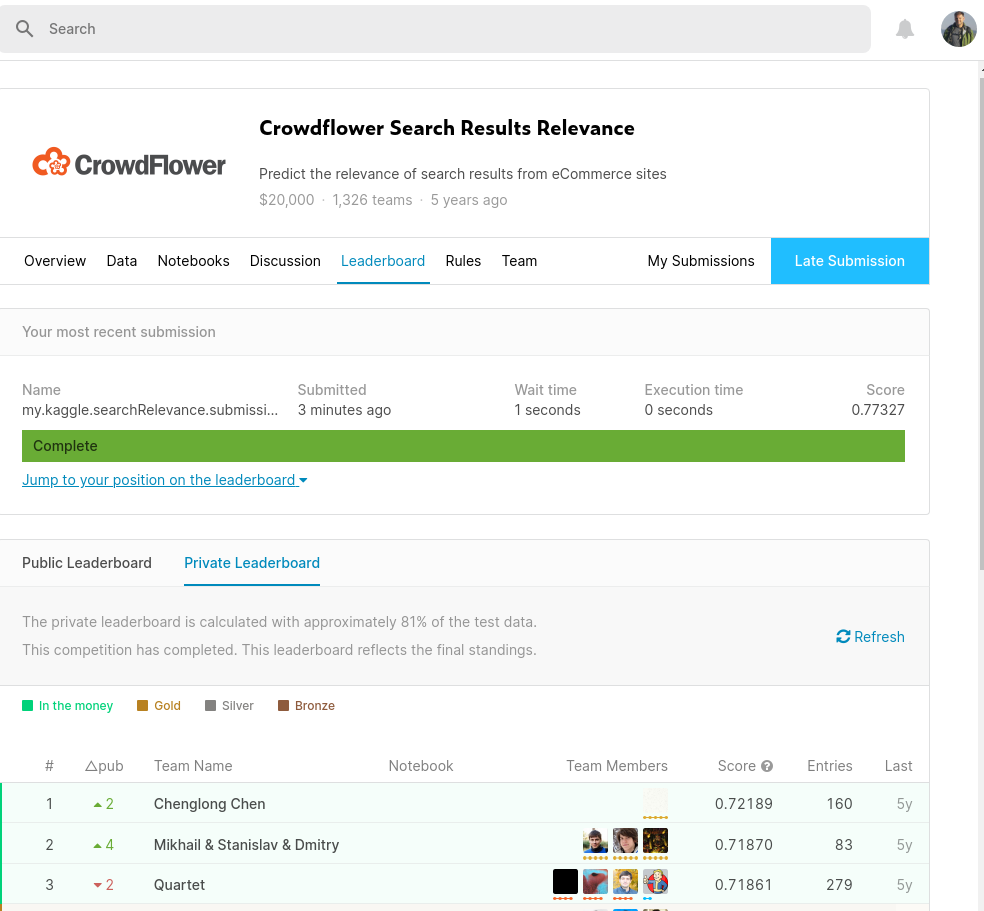

In [1]:
from IPython.display import Image
Image(filename='myLateKaggleWinner.SearchRelevance.png')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
from torch.utils.data import DataLoader
import argparse
import time
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

from dataloader import SearchRelevanceDataset
from transformers import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

I0820 00:31:09.548614 139904012736320 file_utils.py:39] PyTorch version 1.4.0 available.
I0820 00:31:11.283068 139904012736320 file_utils.py:55] TensorFlow version 2.0.0 available.


device(type='cuda')

### To run this notebook, you'll need to agree to the Kaggle license terms and download the data

In [3]:
# the following commented out lines were needed, along with manually editing the column name to convert to utf8 and to avoid a keyword collision
# train_file ='kaggle_ecommerce_complete_Rank_Crowd_AGG_Descriptions_ALL_ROWS.csv'
# train_file_path = f'../data/crowdflower-search-relevance/{train_file}'
# train_df = pd.read_csv(train_file_path, encoding='iso-8859-1' )
# train_df.head()

In [4]:
train_file ='kaggle_ecommerce_complete_Rank_Crowd_AGG_Descriptions_ALL_ROWS_utf8.csv'
train_file_path = f'../data/crowdflower-search-relevance/{train_file}'
# train_df.to_csv(train_file_path, encoding='utf-8', index=False)
# train_df = pd.read_csv(train_file_path)
# train_df.head()

In [5]:
train_df = pd.read_csv(train_file_path)
train_df.head()

,_unit_id,relevance_score,relevance:variance,product_image,product_link,product_price,product_title,query,rank,source,url,product_description
0,711158459,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$329.98,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,playstation 4,1,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...
1,711158460,4.00,0.000,http://thumbs3.ebaystatic.com/d/l225/m/mJNDmSy...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$324.84,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,2,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...
2,711158461,4.00,0.000,http://thumbs4.ebaystatic.com/d/l225/m/m10NZXA...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$324.83,Sony PlayStation 4 PS4 500 GB Jet Black Console,playstation 4,3,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...
3,711158462,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mZZXTmA...,http://www.ebay.com/itm/Sony-PlayStation-4-500...,$350.00,Sony - PlayStation 4 500GB The Last of Us Rema...,playstation 4,4,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN
4,711158463,3.33,0.471,http://thumbs3.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$308.00\nTrending at\n$319.99,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,playstation 4,5,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...


## After inspecting the data, we decide to only use values for which we have relevance scores.
It is left to the reader as an exercise to determine if imputing the missing values would boost the classifier scores. So much low hanging fruit.

In [6]:
train_df.query('relevance_score < 0 | relevance_score.isnull()', engine='python').head()

,_unit_id,relevance_score,relevance:variance,product_image,product_link,product_price,product_title,query,rank,source,url,product_description
20571,713184536,NaN,NaN,http://thumbs1.ebaystatic.com/d/l225/m/mhFJ074...,http://www.ebay.com/itm/Sony-PlayStation-4-Bun...,$430.00,Sony PlayStation 4 Bundle with 6 Games GTA5 A...,playstation 4,26,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN
20572,713184537,NaN,NaN,http://thumbs3.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$350.00,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,27,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN
20573,713184538,NaN,NaN,http://thumbs3.ebaystatic.com/d/l225/m/mZ_dYhk...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$299.99\nTrending at\n$319.99,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,28,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,<ul>\n\t\t<li>\n\t\t\tEnglish \n\t\t\t\t</li>\...
20574,713184539,NaN,NaN,http://thumbs1.ebaystatic.com/d/l225/m/mlPL5eW...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$325.00,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,29,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN
20575,713184540,NaN,NaN,http://thumbs3.ebaystatic.com/d/l225/m/mVjQFAh...,http://www.ebay.com/itm/Sony-PlayStation-4-500...,$273.99\nTrending at\n$319.99,Sony PlayStation 4 - 500 GB PS4 Jet Black --CO...,playstation 4,30,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,<ul>\n\t\t<li>\n\t\t\tEnglish \n\t\t\t\t</li>\...


### In another notebook we might predict this nan values and cross validate, and maybe even manually label, etc. There are all sorts of improvements that can be done, but this notebook focuses on how big results can be gained with just fine tuning BERT in a coarse manner.

In [7]:
len(train_df)

32671

In [8]:
train_df.dropna(subset=['relevance_score'], inplace=True)
len(train_df)

20571

## We'll also collapse the relevance scores into four categories

In [9]:
train_df['median_relevance'] = [int(round((tmp) )) for tmp in train_df['relevance_score'].tolist()]
train_df.head()                                    

,_unit_id,relevance_score,relevance:variance,product_image,product_link,product_price,product_title,query,rank,source,url,product_description,median_relevance
0,711158459,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$329.98,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,playstation 4,1,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...,4
1,711158460,4.00,0.000,http://thumbs3.ebaystatic.com/d/l225/m/mJNDmSy...,http://www.ebay.com/itm/Sony-PlayStation-4-Lat...,$324.84,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,playstation 4,2,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...,4
2,711158461,4.00,0.000,http://thumbs4.ebaystatic.com/d/l225/m/m10NZXA...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$324.83,Sony PlayStation 4 PS4 500 GB Jet Black Console,playstation 4,3,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...,4
3,711158462,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mZZXTmA...,http://www.ebay.com/itm/Sony-PlayStation-4-500...,$350.00,Sony - PlayStation 4 500GB The Last of Us Rema...,playstation 4,4,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4
4,711158463,3.33,0.471,http://thumbs3.ebaystatic.com/d/l225/m/mzvzEUI...,http://www.ebay.com/itm/Sony-PlayStation-4-PS4...,$308.00\nTrending at\n$319.99,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,playstation 4,5,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,The PlayStation 4 system opens the door to an ...,3


In [10]:
ids = train_df['_unit_id'].tolist()
len(ids), len(set(ids))

(20571, 20571)

In [11]:
titles = train_df['product_title'].tolist()
len(titles), len(set(titles))

(20571, 18894)

In [12]:
len(set( train_df['median_relevance'].tolist()))

4

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.to(device)
device

I0820 00:31:19.779527 139904012736320 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/todd/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0820 00:31:20.293649 139904012736320 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/todd/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0820 00:31:20.294543 139904012736320 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LAB

device(type='cuda')

## Let's take a look at the class distribution

In [15]:
print(train_df['median_relevance'].value_counts())

4    11065
3     5411
2     2879
1     1216
Name: median_relevance, dtype: int64


In [16]:
train_df['median_relevance'].value_counts() / len(train_df)

4    0.537893
3    0.263040
2    0.139954
1    0.059112
Name: median_relevance, dtype: float64

## So our baseline to beat is 53%, which we get if we predict the most common class

## Let's create dataframes for training and validation

In [17]:
training_df =  train_df.sample( int(len(train_df) * .9))
validation_df = train_df.query(f'_unit_id not in {training_df._unit_id.tolist() }')
validation_df.head()

,_unit_id,relevance_score,relevance:variance,product_image,product_link,product_price,product_title,query,rank,source,url,product_description,median_relevance
36,711158495,4.00,0.000,http://thumbs1.ebaystatic.com/d/l225/m/mFuQxKo...,http://www.ebay.com/itm/Lancome-High-Resolutio...,$23.50,Lancome High Resolution Eye Cream .95 Oz Refil...,eye cream,12,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4
46,711158505,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/m5EfWbi...,http://www.ebay.com/itm/Jeunesse-Instantly-Age...,$65.99,Jeunesse Instantly Ageless -- New Box Of 50 Sa...,eye cream,22,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4
59,711158518,3.67,0.471,http://thumbs2.ebaystatic.com/d/l225/m/mUPdyhb...,http://www.ebay.com/itm/Netgear-N600-300-Mbps-...,$27.00,Netgear N600 300 Mbps 4-Port 10/100 Wireless N...,routers,10,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4
81,711158540,4.00,0.000,http://thumbs1.ebaystatic.com/d/l225/m/mcrO4Bk...,http://www.ebay.com/itm/Panasonic-ES8103S-Arc3...,$65.88,Panasonic ES8103S Arc3 Electric Shaver Wet/Dry...,shaver panasonic,7,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4
84,711158543,4.00,0.000,http://thumbs4.ebaystatic.com/d/l225/m/mqWDU2m...,http://www.ebay.com/itm/Panasonic-ES3831K-Sing...,$15.76,Panasonic ES3831K Single Blade Wet & Dry Trave...,shaver panasonic,10,eBay,http://www.ebay.com/sch/i.html?_from=R40&_trks...,NaN,4


In [18]:
training_file='../data/crowdflower-search-relevance/mytraining.csv'
validation_file = '../data/crowdflower-search-relevance/myvalidation.csv'

# Do this once
# training_df.to_csv( training_file, index=False)
# validation_df.to_csv(validation_file, index=False)

In [19]:
parser = argparse.ArgumentParser()
parser.add_argument('-gpu', type = int, default = 0)
parser.add_argument('-freeze_bert', action='store_true', default=False)
parser.add_argument('-maxlen', type = int, default= 512)
parser.add_argument('-batch_size', type = int, default=8)
parser.add_argument('-lr', type = float, default = 2e-5)
parser.add_argument('-print_every', type = int, default= 1000)
parser.add_argument('-max_eps', type = int, default=4)
parser.add_argument('-fp16', type=bool, default=True)
args = parser.parse_args(["-gpu", "0"] )

## Creating dataloaders

In [20]:
print("Creating train and val dataloaders")
st = time.time()
train_set = SearchRelevanceDataset(filename = training_file, maxlen = args.maxlen,
                                  tokenizer=tokenizer ,
                                  data_columns=('query', 'product_title',  'product_description'))
val_set = SearchRelevanceDataset(filename = validation_file, maxlen = args.maxlen,
                                tokenizer=tokenizer,
                                data_columns=('query', 'product_title',  'product_description')) 
train_loader = DataLoader(train_set, batch_size = args.batch_size, num_workers = 2, shuffle=True) 
val_loader = DataLoader(val_set, batch_size = args.batch_size, num_workers = 1) 
print("Done in {} seconds".format(time.time() - st))

Creating train and val dataloaders
Done in 0.10383796691894531 seconds


In [21]:
training_stats =[]

def flat_accuracy(preds, labels):
    """Function to calculate the accuracy of our predictions vs labels"""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def evaluate(model, dataloader, args, ep, avg_train_loss):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    t0 = time.time() 
    with torch.no_grad():
        for seq, tok_type_ids, attn_masks, labels in dataloader:
            seq, attn_masks = seq.cuda(args.gpu), attn_masks.cuda(args.gpu)            
            tok_type_ids, labels = tok_type_ids.cuda(args.gpu), labels.cuda(args.gpu)                        
            loss, logits = model(seq, 
                             token_type_ids=None, 
                             attention_mask=attn_masks,
                                 labels=labels) 
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            # Calculate the accuracy for this batch & accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)       

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dataloader)    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': ep + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )
    return avg_val_accuracy, avg_val_loss


def train(model, opti, train_loader, val_loader, args):
    model.zero_grad()
    best_acc = 0        
    for ep in range(args.max_eps):
        # Reset the total loss for this epoch.
        total_train_loss = 0   
        model.train()
        t0 = time.time()  # Measure how long the training epoch takes.
        pbar = tqdm(total=len(train_loader))
        for it, (seq, tok_type_ids, attn_masks, labels) in enumerate(train_loader):                        
            opti.zero_grad()
            seq, attn_masks = seq.cuda(args.gpu), attn_masks.cuda(args.gpu)
            tok_type_ids, labels = tok_type_ids.cuda(args.gpu), labels.cuda(args.gpu)            
            loss, logits = model(seq, 
                             token_type_ids=None, # tok_type_ids
                             attention_mask=attn_masks, 
                             labels=labels)                      

            # Accumulate the training loss for the epoch over all of the batches 
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            if args.fp16:
                with amp.scale_loss(loss, opti) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()    
            
            # Clip the norm of the gradients to 1.0.; to prevent the "exploding gradients" problem.
            if args.fp16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opti), 1.0)
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
            # Update parameters and take a step using the computed gradient.
            opti.step()
            # Update the learning rate.
            scheduler.step()
            model.zero_grad()
            pbar.update(1)
            if it % args.print_every == 0 and it >0:
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = labels.to('cpu').numpy()
                acc = flat_accuracy(logits, label_ids)                               
                print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(it, ep, loss.item(), acc))
        pbar.close()
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_loader)            
        print("Average training loss: {0:.2f}".format(avg_train_loss))        
        try:
            val_acc, val_loss = evaluate(model, val_loader, args, ep, avg_train_loss)
            print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep, val_acc, val_loss))
            if val_acc > best_acc:
                print("Best validation accuracy improved from {} to {}, saving model...".format(best_acc, val_acc))
                best_acc = val_acc
                torch.save(model.state_dict(), 'bert.cls.search.relevance._{}_freeze_{}.dat'.format(ep, args.freeze_bert))
        except Exception as ex:
            LOG.exception('failure %s', str(ex))

In [22]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = args.max_eps #  4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Do you have Apex? If so, training with mixed precision will speed things up

In [23]:
# use Apex if available
try:
    from apex import amp
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1") # s["fp16_opt_level"])
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [24]:
print("Training...")
st = time.time()
train(model, optimizer, train_loader, val_loader, args)
print("Done in {} seconds".format(time.time() - st))

  0%|          | 0/2315 [00:00<?, ?it/s]

Training...


/home/todd/anaconda3/envs/py37-mlyoucanuse/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/2315 [00:00<12:08,  3.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


  9%|▉         | 211/2315 [00:45<06:54,  5.07it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 43%|████▎     | 1001/2315 [03:36<04:38,  4.71it/s]

Iteration 1000 of epoch 0 complete. Loss : 1.4627025127410889 Accuracy : 0.375


 86%|████████▋ | 2001/2315 [07:09<01:07,  4.64it/s]

Iteration 2000 of epoch 0 complete. Loss : 0.6471481323242188 Accuracy : 0.875


100%|██████████| 2315/2315 [08:15<00:00,  4.67it/s]

Average training loss: 0.92


  Accuracy: 0.66
  Validation Loss: 0.82
Epoch 0 complete! Validation Accuracy : 0.6589147286821705, Validation Loss : 0.823971323957739
Best validation accuracy improved from 0 to 0.6589147286821705, saving model...


  2%|▏         | 41/2315 [00:08<07:21,  5.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 43%|████▎     | 1001/2315 [03:29<04:31,  4.84it/s]

Iteration 1000 of epoch 1 complete. Loss : 1.1968224048614502 Accuracy : 0.375


 86%|████████▋ | 2001/2315 [07:01<01:07,  4.62it/s]

Iteration 2000 of epoch 1 complete. Loss : 0.811937153339386 Accuracy : 0.625


 88%|████████▊ | 2046/2315 [07:10<00:52,  5.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 2315/2315 [08:06<00:00,  4.76it/s]

Average training loss: 0.77


  Accuracy: 0.67
  Validation Loss: 0.82
Epoch 1 complete! Validation Accuracy : 0.6724806201550387, Validation Loss : 0.8170255799741708
Best validation accuracy improved from 0.6589147286821705 to 0.6724806201550387, saving model...


 11%|█         | 248/2315 [00:51<06:36,  5.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 43%|████▎     | 1001/2315 [03:35<04:45,  4.60it/s]

Iteration 1000 of epoch 2 complete. Loss : 1.0405322313308716 Accuracy : 0.5


 86%|████████▋ | 2001/2315 [07:04<01:05,  4.78it/s]

Iteration 2000 of epoch 2 complete. Loss : 0.8550999164581299 Accuracy : 0.625


100%|██████████| 2315/2315 [08:09<00:00,  4.73it/s]

Average training loss: 0.68


  Accuracy: 0.68
  Validation Loss: 0.81
Epoch 2 complete! Validation Accuracy : 0.6841085271317829, Validation Loss : 0.8112265705600266
Best validation accuracy improved from 0.6724806201550387 to 0.6841085271317829, saving model...


 23%|██▎       | 542/2315 [01:56<06:26,  4.58it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 43%|████▎     | 1001/2315 [03:34<04:37,  4.73it/s]

Iteration 1000 of epoch 3 complete. Loss : 0.9393256902694702 Accuracy : 0.625


 61%|██████    | 1408/2315 [04:56<02:54,  5.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


 86%|████████▋ | 2001/2315 [07:04<01:07,  4.66it/s]

Iteration 2000 of epoch 3 complete. Loss : 0.32130324840545654 Accuracy : 0.875


100%|██████████| 2315/2315 [08:13<00:00,  4.69it/s]

Average training loss: 0.59


  Accuracy: 0.68
  Validation Loss: 0.88
Epoch 3 complete! Validation Accuracy : 0.6792635658914729, Validation Loss : 0.8823379663995994
Done in 2026.2599093914032 seconds


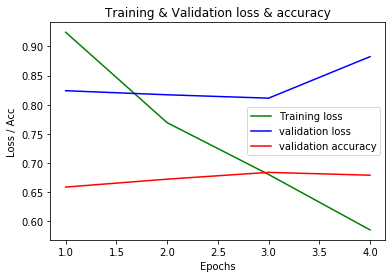

In [30]:
loss_train = [ep['Training Loss'] for ep in training_stats]
loss_val = [ep['Valid. Loss'] for ep in training_stats]
acc_val = [ep['Valid. Accur.'] for ep in training_stats]
epochs = list(range(1,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.plot(epochs, acc_val, 'r', label='validation accuracy')
plt.title('Training & Validation loss & accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Acc')
plt.legend()
plt.show()

## The graph shows a lot of improvement could be made, but, sadly, we'll see it's good enough to beat the previous SOTA

## Evaluate

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions, true_labels = [], []
# Predict 
for batch in val_loader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_tok_types, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        loss, logits = model(b_input_ids, 
                             token_type_ids=b_tok_types, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)   
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()  
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

# Flatten the predictions and true values for evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy_score(flat_true_labels, flat_predictions)

0.6622934888241011

In [32]:
print('labels', val_set.label_encoder.classes_)

target_names = [ str(tmp) for tmp in val_set.label_encoder.classes_.tolist()]
print(classification_report(flat_true_labels, flat_predictions, target_names=target_names))

labels [1 2 3 4]
              precision    recall  f1-score   support

           1       0.64      0.50      0.56       111
           2       0.49      0.47      0.48       260
           3       0.49      0.45      0.47       568
           4       0.78      0.83      0.80      1119

    accuracy                           0.66      2058
   macro avg       0.60      0.56      0.58      2058
weighted avg       0.65      0.66      0.66      2058



In [33]:
model.save_pretrained('mymodel')
tokenizer.save_pretrained('mymodel')

I0820 01:11:56.681124 139904012736320 configuration_utils.py:144] Configuration saved in mymodel/config.json
I0820 01:11:57.829241 139904012736320 modeling_utils.py:483] Model weights saved in mymodel/pytorch_model.bin


('mymodel/vocab.txt',
 'mymodel/special_tokens_map.json',
 'mymodel/added_tokens.json')

## Let's load the test data and prepare it to make a submission

In [34]:
test_file ='../data/crowdflower-search-relevance/test.csv'
test_df = pd.read_csv(test_file)
test_df.head()

,id,query,product_title,product_description
0,3,electric griddle,Star-Max 48 in Electric Griddle,NaN
1,6,phillips coffee maker,Philips SENSEO HD7810 WHITE Single Serve Pod C...,NaN
2,9,san francisco 49ers,2013 San Francisco 49ers Clock,A 2013 San Francisco 49ers clock is the ultima...
3,11,aveeno shampoo,AVEENO 10.5FLOZ NRSH SHINE SH,"Water, Ammonium Lauryl Sulfate, Dimethicone, S..."
4,12,flea and tick control for dogs,Merial Frontline Plus Flea and Tick Control fo...,NaN


In [35]:
test_df['product_title'].fillna('', inplace=True)
test_df['product_description'].fillna('', inplace=True)

In [36]:
test_set = SearchRelevanceDataset(filename = test_file, maxlen = args.maxlen,
                                tokenizer=tokenizer,
                                data_columns=('query', 'product_title',  'product_description')
                                 , label_name=None)  
test_loader = DataLoader(test_set, batch_size = args.batch_size, num_workers = 1, shuffle=False)  

## Let's prove we can reconstitute our model and make predictions for a submission

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in tqdm(test_loader, total=len(test_loader)):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_tok_types, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        loss, logits = model(b_input_ids, 
                             token_type_ids=b_tok_types, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)   
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()  
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

submission_file = 'my.kaggle.searchRelevance.submission.csv'
ids = test_df['id'].tolist()
corrected_preds =[tmp +1 for tmp in flat_predictions]
my_submission = pd.DataFrame({"id": ids, "prediction": corrected_preds})
my_submission.to_csv(submission_file, index=False)

100%|██████████| 2815/2815 [02:37<00:00, 17.82it/s]


In [38]:
! ls my.kaggle.searchRelevance.submission.csv

my.kaggle.searchRelevance.submission.csv


In [39]:
my_submission.head()

,id,prediction
0,3,4
1,6,4
2,9,3
3,11,4
4,12,4


In [40]:
print(len(my_submission))
my_submission['prediction'].value_counts() / len(my_submission)

22513


4    0.570959
3    0.260916
2    0.131035
1    0.037090
Name: prediction, dtype: float64

## Now, in this next cell, we will invoke a time machine to take us back to when the contest was still running...
Let me know if you beat this baseline.